# Bond Option Pricing Tree Convergence with Volatility

Value an option on a coupon paying bond using the Hull-White, Black-Derman-Toy and Black-Karasinski model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.finutils import *
from financepy.market.curves import *
from financepy.models import FinModelRatesBK
from financepy.models import FinModelRatesBDT
from financepy.models import FinModelRatesHW
from financepy.products.bonds import *

###################################################################
# FINANCEPY BETA Version 0.180 - This build: 22 Sep 2020 at 19:38 #
#     This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy #
###################################################################



## Set up the Discount Curve

In [3]:
settlementDate = FinDate(1, 9, 2019)

Set up discount curve

In [4]:
rate = 0.05
fixedFreq = FinFrequencyTypes.ANNUAL
discountCurve = FinDiscountCurveFlat(settlementDate, rate, fixedFreq)

## Setting up the Bond

In [5]:
issueDate = FinDate(1, 9, 2014)
maturityDate = FinDate(1, 9, 2025)
coupon = 0.06
frequencyType = FinFrequencyTypes.ANNUAL
accrualType = FinDayCountTypes.ACT_ACT_ICMA
bond = FinBond(issueDate, maturityDate, coupon, frequencyType, accrualType)

face = 100.0

In [46]:
bond._flowDates

[MON 01 SEP 2014,
 TUE 01 SEP 2015,
 THU 01 SEP 2016,
 FRI 01 SEP 2017,
 SAT 01 SEP 2018,
 SUN 01 SEP 2019,
 TUE 01 SEP 2020,
 WED 01 SEP 2021,
 THU 01 SEP 2022,
 FRI 01 SEP 2023,
 SUN 01 SEP 2024,
 MON 01 SEP 2025]

In [47]:
bond._flowAmounts

[0.0, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06]

## Setting up the Option

In [6]:
expiryDate = FinDate(1, 12, 2021)

Calculate the intrinsic

In [20]:
K = 102

In [21]:
df = discountCurve.df(expiryDate)

Spot price and intrinsic

In [22]:
sp = bond.cleanPriceFromDiscountCurve(settlementDate, discountCurve)
fp = bond.cleanPriceFromDiscountCurve(expiryDate, discountCurve)

In [23]:
print("Spot Bond Price: %9.5f" % sp)
print("Forward Bond Price: %9.5f" % fp)

Spot Bond Price: 105.07523
Forward Bond Price: 103.31706


In [24]:
callIntrinsic = max(sp - K, 0)
putIntrinsic = max(K - sp, 0)

In [25]:
print("Call Intrinsic Spot: %9.5f" % callIntrinsic)
print("Put  Intrinsic Spot: %9.5f" % putIntrinsic)

Call Intrinsic Spot:   3.07523
Put  Intrinsic Spot:   0.00000


Forward bond price and PV of intrinsic

In [26]:
callIntrinsicPV = max(fp - K, 0) * df
putIntrinsicPV = max(K - fp, 0) * df

In [27]:
print("Call Intrinsic Fwd: %9.5f" % callIntrinsicPV)
print("Put  Intrinsic Fwd: %9.5f" % putIntrinsicPV)

Call Intrinsic Fwd:   1.18017
Put  Intrinsic Fwd:   0.00000


## Convergence Testing

It is important that the tree price is stable to the number of tree steps. This can be a challenge when pricing American optionality on bonds due to the payment of coupons and the effect of accrued interest on the clean bond price.

We set the range of num steps.

In [36]:
numStepsVector = range(500, 1000, 1)

In [37]:
blackVol = 0.20

## Hull White Model

It is important that the tree price is stable to the number of tree steps. This can be a challenge when pricing American optionality on bonds due to the payment of coupons and the effect of accrued interest on the clean bond price.

In [38]:
sigma = blackVol * rate
a = 0.1

vec_ec = []
vec_ac = []
vec_ep = []
vec_ap = []

for numSteps in numStepsVector:
    
    hwModel = FinModelRatesHW(sigma, a, numSteps)
    
    europeanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlementDate, discountCurve, hwModel)

    americanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlementDate, discountCurve, hwModel)
    
    europeanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlementDate, discountCurve, hwModel)
    
    americanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlementDate, discountCurve, hwModel)
    
    vec_ec.append(v_ec)
    vec_ac.append(v_ac)
    vec_ep.append(v_ep)
    vec_ap.append(v_ap)

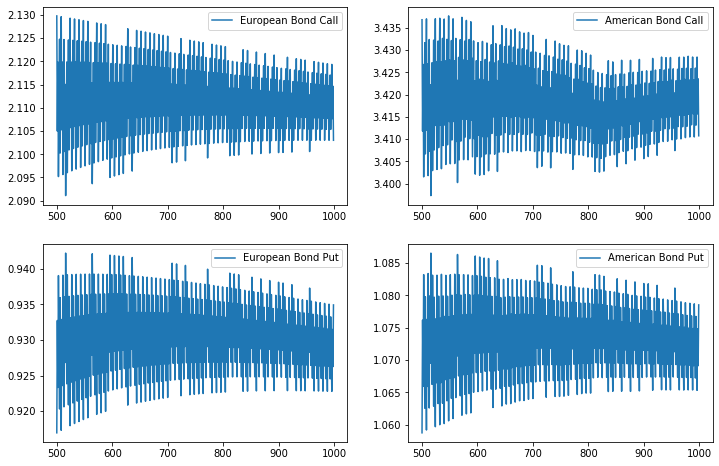

In [39]:
fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(numStepsVector,vec_ec, label="European Bond Call")
plt.legend()

plt.subplot(2,2,2)
plt.plot(numStepsVector,vec_ac, label="American Bond Call")
plt.legend();

plt.subplot(2,2,3)
plt.plot(numStepsVector,vec_ep, label="European Bond Put")
plt.legend();

plt.subplot(2,2,4)
plt.plot(numStepsVector,vec_ap, label="American Bond Put")
plt.legend();

Convergence is good. Averaging even and odd should help smooth.

## Black-Karasinski Model

In [42]:
sigma = blackVol
a = 0.1

vec_ec = []
vec_ac = []
vec_ep = []
vec_ap = []

for numSteps in numStepsVector:
    
    bkModel = FinModelRatesBK(sigma, a, numSteps)
    
    europeanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlementDate, discountCurve, bkModel)

    americanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlementDate, discountCurve, bkModel)
    
    europeanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlementDate, discountCurve, bkModel)
    
    americanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlementDate, discountCurve, bkModel)
    
    vec_ec.append(v_ec)
    vec_ac.append(v_ac)
    vec_ep.append(v_ep)
    vec_ap.append(v_ap)

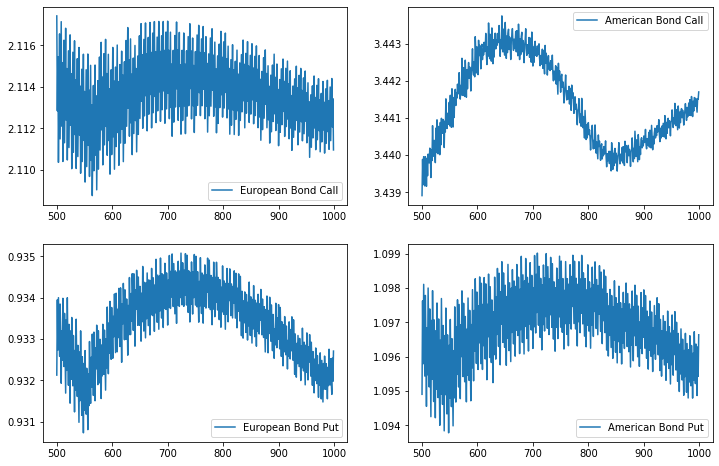

In [43]:
fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(numStepsVector,vec_ec, label="European Bond Call")
plt.legend()

plt.subplot(2,2,2)
plt.plot(numStepsVector,vec_ac, label="American Bond Call")
plt.legend();

plt.subplot(2,2,3)
plt.plot(numStepsVector,vec_ep, label="European Bond Put")
plt.legend();

plt.subplot(2,2,4)
plt.plot(numStepsVector,vec_ap, label="American Bond Put")
plt.legend();

## Black-Derman-Toy Model


In [44]:
sigma = blackVol

vec_ec = []
vec_ac = []
vec_ep = []
vec_ap = []

for numSteps in numStepsVector:
    
    bdtModel = FinModelRatesBDT(sigma, numSteps)
    
    europeanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlementDate, discountCurve, bdtModel)

    americanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlementDate, discountCurve, bdtModel)
    
    europeanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlementDate, discountCurve, bdtModel)
    
    americanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlementDate, discountCurve, bdtModel)
    
    vec_ec.append(v_ec)
    vec_ac.append(v_ac)
    vec_ep.append(v_ep)
    vec_ap.append(v_ap)

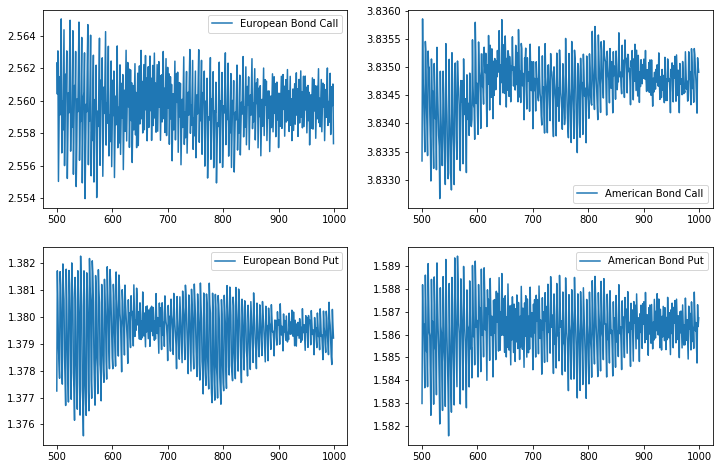

In [45]:
fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(numStepsVector,vec_ec, label="European Bond Call")
plt.legend()

plt.subplot(2,2,2)
plt.plot(numStepsVector,vec_ac, label="American Bond Call")
plt.legend();

plt.subplot(2,2,3)
plt.plot(numStepsVector,vec_ep, label="European Bond Put")
plt.legend();

plt.subplot(2,2,4)
plt.plot(numStepsVector,vec_ap, label="American Bond Put")
plt.legend();

Copyright (c) Dominic O'Kane 2020